In [1]:
%cd ..

/home/proste/mff/evgena


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import struct

from evgena.utils.large_files import file_sha256, maybe_download

In [4]:
def read_header(fp):
    # read header
    magic, type_code, dim_count = struct.unpack('>HBB', fp.read(4))

    # check magic
    if magic != 0:
        raise ValueError('invalid magic number; expected: 0, found: {!r}'.format(magic))

    # construct shape from header
    shape = struct.unpack('>' + 'i' * dim_count, fp.read(4 * dim_count))

    return magic, type_code, dim_count, shape

def type_code_to_dtype(type_code: int) -> np.dtype:
    if type_code == 0x08:
        return np.dtype('B')
    elif type_code == 0x09:
        return np.dtype('b')
    elif type_code == 0x0B:
        return np.dtype('>i2')
    elif type_code == 0x0C:
        return np.dtype('>i4')
    elif type_code == 0x0D:
        return np.dtype('>f4')
    elif type_code == 0x0E:
        return np.dtype('>f8')
    else:
        raise ValueError('invalid type code; found {!r}'.format(type_code))
        
def to_ndarray(path):
    with open(path, 'rb') as file:
        # read in fixed part of header
        magic, type_code, dim_count, shape = read_header(file)

        # load data, reshape, change endianess
        array = np.fromfile(file, dtype=type_code_to_dtype(type_code))
        array = np.reshape(array, shape)
        return array.byteswap(True)

## Initialization
- define `dataset_source_dir` - the directory with standart MNIST formatted dataset
- define `dataset_target_path` - path where to store converted dataset .npz
- define `synset` - array when indexed with labels yielding corresponding names
- optionally define metadata - license, source etc.

In [47]:
dataset_source_dir = 'datasets/fashion_mnist/'
dataset_target_path = 'datasets/fashion_mnist.npz'

synset = np.array([
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
])

metadata = {
    'license': np.array(["""The MIT License (MIT) Copyright © 2017 Zalando SE, https://tech.zalando.com

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE."""
]),
    'source': np.array(['https://github.com/zalandoresearch/fashion-mnist'])
}

## Load MNIST like dataset

In [48]:
print('Converting MNIST like dataset from {source} to {target}'.format(
    source=dataset_target_path, target=dataset_target_path
))

train_X_path = dataset_source_dir + 'train-images-idx3-ubyte'
train_y_path = dataset_source_dir + 'train-labels-idx1-ubyte'
test_X_path = dataset_source_dir + 't10k-images-idx3-ubyte'
test_y_path = dataset_source_dir + 't10k-labels-idx1-ubyte'

print('\tloading train_X from: {}'.format(train_X_path), end='')
train_X = to_ndarray(train_X_path)
print('; shape: {}'.format(train_X.shape))
print('\tloading train_X from: {}'.format(train_y_path), end='')
train_y = to_ndarray(train_y_path)
print('; shape: {}'.format(train_y.shape))
print('\tloading train_X from: {}'.format(test_X_path), end='')
test_X = to_ndarray(test_X_path)
print('; shape: {}'.format(test_X.shape))
print('\tloading train_X from: {}'.format(test_y_path), end='')
test_y = to_ndarray(test_y_path)
print('; shape: {}'.format(test_y.shape))

assert train_X.shape[1:] == test_X.shape[1:],\
    'Example shape mismatch between train and test set'

print('Normalizing images to [0.0,1.0] float32')
train_X = train_X.astype('f4') / 255.
test_X = test_X.astype('f4') / 255.

Converting MNIST like dataset from datasets/fashion_mnist.npz to datasets/fashion_mnist.npz
	loading train_X from: datasets/fashion_mnist/train-images-idx3-ubyte; shape: (60000, 28, 28)
	loading train_X from: datasets/fashion_mnist/train-labels-idx1-ubyte; shape: (60000,)
	loading train_X from: datasets/fashion_mnist/t10k-images-idx3-ubyte; shape: (10000, 28, 28)
	loading train_X from: datasets/fashion_mnist/t10k-labels-idx1-ubyte; shape: (10000,)
Normalizing images to [0.0,1.0] float32


## Save NPrecord dataset
- at this point you can optionally modify loaded dataset - change shapes, restructure splits etc.

In [60]:
example_type = np.dtype([('X', 'f4', train_X.shape[1:]), ('y', 'B')])

train = np.rec.fromarrays((train_X, train_y), dtype=example_type)
test = np.rec.fromarrays((test_X, test_y), dtype=example_type)

print('Writing dataset to {}'.format(dataset_target_path))
np.savez(dataset_target_path, train=train, test=test, synset=synset, **metadata)

print('\nDataset checksum: {}'.format(file_sha256(dataset_target_path)))

Writing dataset to datasets/fashion_mnist.npz

Dataset checksum: f6ed33b2819f8aaa4347c79c2909b60a57804a3b2048a4561fbdb73fb5632605


## Test converted dataset

In [66]:
dataset = np.load(dataset_target_path)
load_train = dataset['train'].view(np.recarray)
load_test = dataset['test'].view(np.recarray)
load_synset = dataset['synset']

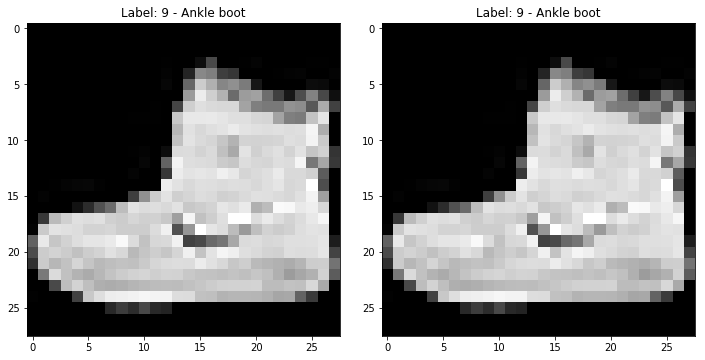

In [59]:
index = 0

fig, ax = plt.subplots(ncols=2, figsize=(10,6))
fig.tight_layout()

ax[0].set_title('Label: {l} - {s}'.format(l=train.y[index], s=synset[train.y[index]]))
ax[0].imshow(train.X[index], cmap='gray')

ax[1].set_title('Label: {l} - {s}'.format(l=load_train.y[index], s=synset[load_train.y[index]]))
ax[1].imshow(load_train.X[index], cmap='gray')